# Silver Data Cleaning

**Purpose:** Clean raw data from the [Bronze](./1_bronze.ipynb) layer to create a unified data asset. This includes column standardization, data type enforcement, value harmonization, deduplication, and provenance tracking.

**Transformations Applied:**
- **Standardize** column names to lowercase snake_case
- **Tag** each row with its source region for provenance
- **Harmonize** categorical values across data sources
- **Enforce** consistent data types

This data will be used when creating [Gold](./3_gold.ipynb), where tailored data assets will be created to efficiently answer specific questions.


For more on Medallion Architecture, see [Databricks Glossary: Medallion Architecture](https://www.databricks.com/glossary/medallion-architecture) (Databricks, n.d.).

-----


## Table of Contents

1. [Setup](#1-setup)  
   Install required packages and import libraries.

1. [Configuration & Data Loading](#2-configuration-and-data-loading)  
   Centralize file paths, API parameters, and date-column lists, then ingest the raw Bronze dataset into pandas.

1. [Define Helper Functions](#3-define-helper-functions)  
   Define all cleaning and enrichment transforms as modular functions—date anomaly filters, age parsers, imputation routines, etc.

1. [Data Cleaning & Standardization](#4-data-cleaning--standardization)  
   Harmonize column names, drop duplicates, and enforce schema across sources.

1. [Value Mapping & Data Type Enforcement](#5-value-mapping--data-type-enforcement)  
   Apply categorical/value mappings and cast explicit dtypes for Silver.

1. [Execute Transformations](#6-execute-transformations)  
   Run each helper function in sequence to clean and enrich the DataFrame.

1. [Create Silver](#7-create-silver)  
   Inspect missingness, distributions, date ranges, and trends to validate Silver.

1. [Post-Processing of the Silver Data](#8-post-processing-of-the-silver-data)

    8.1. [Compute Age from Intake and DOB](#81-compute-age-from-intake-and-dob)

    8.2. [Apply species-specific median imputations for missing ages](#82-apply-species-specific-median-imputations-for-missing-ages)

    8.3. [Bin Ages into 3 Life Stages (Puppy/Kitten, Adult, Senior)](#83-bin-ages-into-3-life-stages-puppykitten-adult-senior)

    8.4. [Extract Sex from Health, Apply Imputation for Missing Sex](#84-extract-sex-from-health-apply-imputation-for-missing-sex)

    8.5. [Apply Imputation to Assign Sex Based on Group Distribution](#85-apply-imputation-to-assign-sex-based-on-group-distribution)

    8.6. [Apply Imputation to Assign Primary Color for Missing Values](#86-apply-imputation-to-assign-primary-color-for-missing-values) 

1. [Materialize Silver](#9-materialize-silver)
   Add in description

1. [Data Quality Assessment](#10-data-quality-assessment)
   Add in description

1. [References](#11-references)

-----

## 1. Setup

**Purpose:**  
Ensure the environment has all necessary libraries installed and imported.  
```python
# Install project-wide dependencies
%pip install -r ../../requirements.txt
``` 

> **Note:** we use a project-wide `requirements.txt` for consistency

In [85]:
%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [86]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

-----

## 2. Configuration and Data Loading

**Purpose:**
Here we centralize file paths, API endpoints, and date-column definitions, then ingest every raw Bronze source.

In [87]:
# Data source configurations
BRONZE_DIR = "../../data-assets/bronze"
BRONZE_FILE_NAME = "{}_df.parquet"

# Load all the Bronze datasets
BRONZE_FILES = ["dallas", "san_jose", "soco"]
BRONZE_FILE_PATHS = {
    file: os.path.join(BRONZE_DIR, BRONZE_FILE_NAME.format(file))
    for file in BRONZE_FILES
}
BRONZE_DFS = {file: pd.read_parquet(path) for file, path in BRONZE_FILE_PATHS.items()}

-----

## 3. Define Helper Functions

**Purpose:**
Below, we define some functions to help us with our transformations.

In [88]:
# ─── Data Cleaning ───

# Function to apply the column mapping
def standardize_columns(source: str, df: pd.DataFrame, mapping: dict) -> pd.DataFrame:
    """
    Standardize DataFrame column names using mapping, lowercase, and remove duplicates.

    Parameters
    ----------
    df : pandas.DataFrame
        Raw DataFrame to standardize
    mapping : dict
        Column name mapping (original -> standardized)

    Returns
    -------
    pandas.DataFrame
        DataFrame with renamed, lowercased columns and duplicates removed
    """
    # Apply the renaming mapping
    df = df.rename(columns=mapping)
    # Convert all column names to lowercase
    df.columns = df.columns.str.lower()
    # Remove duplicate columns, keeping the first occurrence
    df = df.loc[:, ~df.columns.duplicated()]
    print(f" - {source}: {list(df.columns)}")
    return df


def apply_silver_transforms(df: pd.DataFrame, source: str) -> pd.DataFrame:
    """
    Apply comprehensive silver-layer transformations to a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with standardized columns
    source : str
        Source identifier for provenance tracking

    Returns
    -------
    pd.DataFrame
        Transformed DataFrame with harmonized values and proper types
    """
    # Add provenance
    df["region"] = source

    # Ensure intake_reason column exists
    if "intake_reason" not in df.columns:
        df["intake_reason"] = pd.NA

    # Apply data types
    for col, dtype in SILVER_DTYPES.items():
        if col in df.columns:
            if dtype == "datetime64[ns]":
                df[col] = pd.to_datetime(df[col], errors="coerce")
            elif col == "age":
                # Clean age strings like "6 MONTHS", "2 YEARS", etc.
                age_str = df[col].astype(str).str.strip().str.upper()

                extracted = age_str.str.extract(
                    r"(?P<value>\d+\.?\d*)\s*(?P<unit>YEAR|YEARS|MONTH|MONTHS)?"
                )
                extracted["value"] = extracted["value"].astype(float)

                # Convert months to years if unit is MONTH(S)
                df[col] = extracted.apply(
                    lambda row: row["value"] / 12
                    if row["unit"] in ["MONTH", "MONTHS"]
                    else row["value"],
                    axis=1,
                )
            else:
                df[col] = df[col].astype(dtype)

    # Data validation: Check for future dates
    current_date = pd.Timestamp.now().normalize()
    date_columns = ["intake_date", "outcome_date"]

    for col in date_columns:
        if col in df.columns:
            future_dates = df[col] > current_date
            if future_dates.any():
                future_count = future_dates.sum()
                max_future_date = df.loc[future_dates, col].max()
                print(
                    f"WARNING: Found {future_count:,} future dates in {col} for {source}"
                )
                print(f"         Latest future date: {max_future_date.date()}")
                print("         Setting future dates to NaT (Not a Time)")

                # Set future dates to NaT
                df.loc[future_dates, col] = pd.NaT

    # Harmonize categorical values
    for col, mapping in VALUE_MAPPINGS.items():
        if col in df.columns:
            # Normalize text before mapping
            normalized = df[col].astype(str).str.strip().str.upper()
            df[col] = normalized.map(mapping).fillna(
                "other" if col != "intake_reason" else "unknown"
            )

    return df


def create_silver_dataset(
    dataframes: dict[str, pd.DataFrame], schema: list[str]
) -> pd.DataFrame:
    """
    Combine multiple source DataFrames into unified silver dataset.

    Parameters
    ----------
    dataframes : dict[str, pd.DataFrame]
        Source DataFrames to combine
    schema : list[str]
        Final column schema to enforce

    Returns
    -------
    pd.DataFrame
        Unified silver dataset
    """
    # Combine all sources
    combined = pd.concat(dataframes.values(), ignore_index=True, sort=False)

    # Enforce schema
    return (
        combined.reindex(columns=schema)
        # .drop_duplicates() Dropping duplicates may miss repeat intakes TBD
        .reset_index(drop=True)
    )


def create_cardinality_summary(dataframes: dict, columns: list) -> pd.DataFrame:
    """Create cardinality summary showing unique value counts by source and column."""

    summary = (
        pd.DataFrame(
            {
                source: {
                    col: df[col].nunique(dropna=True)  # Count unique non-null values
                    for col in columns
                    if col in df  # Skip missing columns
                }
                for source, df in dataframes.items()  # Process each data source
            }
        )
        .fillna(0)  # Missing columns = 0 unique values
        .astype(int)  # Convert to clean integers
        .T  # Transpose: sources as rows, columns as features
    )

    # Return with integer formatting
    return summary.style.format("{:d}")


def generate_data_overview(df: pd.DataFrame) -> None:
    """
    Generate comprehensive data quality overview.

    Parameters
    ----------
    df : pd.DataFrame
        Dataset to profile
    """
    print("=" * 60)
    print("DATA QUALITY PROFILE")
    print("=" * 60)

    # Dataset overview
    print("\nDATASET OVERVIEW")
    print(f"Total records: {df.shape[0]:,}")
    print(f"Total columns: {df.shape[1]}")

    # Missing data analysis
    print("\nMISSING DATA ANALYSIS")
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df) * 100).round(3)

    for col in missing_data.index:
        if missing_data[col] > 0:
            # change missing_pcft to .4f
            print(f"  {col}: {missing_data[col]:,} ({missing_pct[col]:.3f}%)")

    # Cardinality analysis
    print("\nCARDINALITY ANALYSIS")
    cardinality = df.nunique().sort_values(ascending=False)
    for col, count in cardinality.items():
        print(f"  {col}: {count:,} unique values")

    # Categorical distributions
    categorical_cols = [
        "intake_type",
        "animal_type",
        "breed",
        "primary_color",
        "intake_condition",
        "intake_reason",
        "outcome_type",
        "animal_type",
    ]

    for col in categorical_cols:
        if col in df.columns:
            print(f"\n{col.upper()} DISTRIBUTION")
            dist = df[col].value_counts(normalize=True).head(10)
            for value, pct in dist.items():
                print(f"  {value}: {pct:.1%}")

    # Temporal analysis
    print("\nTEMPORAL ANALYSIS")
    if "intake_date" in df.columns:
        date_range = df["intake_date"].agg(["min", "max"])
        print(
            f"  Intake date range: {date_range['min'].date()} to {date_range['max'].date()}"
        )

        # Monthly trends
        monthly = df.set_index("intake_date").resample("M").size()
        print(f"  Average monthly intake: {monthly.mean():.0f} animals")
        print(
            f"  Peak month: {monthly.idxmax().strftime('%B %Y')} ({monthly.max():,} animals)"
        )


def compute_age_from_dates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the age from dates intake date and date of birth
    """
    if {"age", "intake_date", "date_of_birth"}.issubset(df.columns):
        # Convert date columns to datetime if not already
        df["intake_date"] = pd.to_datetime(df["intake_date"], errors="coerce")
        df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors="coerce")

        # Create a mask for the rows where age is missing but both intake_date and date_of_birth are available
        mask = (
            df["age"].isna() & df["intake_date"].notna() & df["date_of_birth"].notna()
        )

        df.loc[mask, "age"] = (
            df.loc[mask, "intake_date"] - df.loc[mask, "date_of_birth"]
        ).dt.days / 365.25
        print(f"Computed age for {mask.sum()} rows")
    return df


def impute_missing_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply Imputation (missing age using species - specific median)
    """
    if "animal_type" in df.columns and "age" in df.columns:
        for species in df["animal_type"].dropna().unique():
            species_mask = df["animal_type"] == species
            median_age = df.loc[species_mask, "age"].median()
            missing_mask = species_mask & df["age"].isna()
            df.loc[missing_mask, "age"] = median_age
            print(
                f"Imputed {missing_mask.sum()} missing ages for species: {species} (median={median_age:.2f})"
            )
    return df


def bin_age_into_life_stages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Bin ages in accordance to life stage (Puppy/Kitten, adult, senior)
    """

    def categorize(row):
        if pd.isna(row["age"]) or pd.isna(row["animal_type"]):
            return pd.NA
        if row["age"] < 0.5:
            return (
                "puppy"
                if row["animal_type"] == "dog"
                else ("kitten" if row["animal_type"] == "cat" else pd.NA)
            )
        elif row["age"] < 7:
            return "adult"
        else:
            return "senior"

    df["age_stage"] = df.apply(categorize, axis=1).astype("category")
    print("Added 'age_stage' column with categories: puppy/kitten, adult, senior")
    return df


def recatogarize_sex(df: pd.DataFrame) -> pd.DataFrame:
    """
    Harmonizing male and female
    """
    male_terms = ["MALE", "Male", "NEUTERED", "Neutered"]
    female_terms = ["FEMALE", "Female", "SPAYED", "Spayed"]

    df["sex"] = df["sex"].apply(
        lambda x: "male"
        if x in male_terms
        else "female"
        if x in female_terms
        else pd.NA
    )
    return df


def impute_sex_by_species_and_breed(df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    Populating missing columns based on statistical distribution.
    Logic is, I would like to observe the distribution of two key values when assigning "sex" for missing values : 1_animal_type , 2_breed. The logic is
    for each row that is missing "sex", a compiled probability dictionary is referenced for a specific group based on the aformentioned key values.
    using numpy random seed to assign sex based on probability distribution for each group.
    """
    # Set seed for reproducibility - 42 because its the most popular number
    np.random.seed(seed)
    # Get normalized sex distributions per (animal_type, breed)
    sex_probs = (
        df.dropna(subset=["sex"])
        .groupby(["animal_type", "breed"])["sex"]
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
    )

    # Convert to lookup dictionary for speed
    sex_prob_dict = sex_probs.to_dict(orient="index")

    def sample_sex(row):
        """The sampling and random logic based on distribution of sex (male/female)"""
        if pd.notna(row["sex"]):
            return row["sex"]
        key = (row["animal_type"], row["breed"])
        p = sex_prob_dict.get(key)
        if p and (p.get("male", 0) + p.get("female", 0)) > 0:
            return np.random.choice(
                ["male", "female"], p=[p.get("male", 0), p.get("female", 0)]
            )
        return pd.NA

    df["sex"] = df.apply(sample_sex, axis=1)
    return df


def impute_primary_color_by_species_and_breed(
    df: pd.DataFrame, seed: int = 42
) -> pd.DataFrame:
    """
    Utilizing the same logic used for sex, we are able to do the same for primary color missing values
    By going through all the rows and grouping them according to species & breed while making note of the color associated with each pair
    We can assign a probability to each color, compiling a color distribution for each species-breed pair.
    hence, randomly assigning a color using those accumulated probabilities for each missing row.
    """
    np.random.seed(seed)

    # Compute normalized primary_color probabilities per group
    color_probs = (
        df.dropna(subset=["primary_color"])
        .groupby(["animal_type", "breed"])["primary_color"]
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
    )

    # Convert to lookup dictionary
    color_prob_dict = color_probs.to_dict(orient="index")

    # The sampling and random logic based on distribution of primary color (species/breed to assign color)
    def sample_color(row):
        if pd.notna(row["primary_color"]):
            return row["primary_color"]
        key = (row["animal_type"], row["breed"])
        p = color_prob_dict.get(key)
        if p and sum(p.values()) > 0:
            choices = list(p.keys())
            probabilities = list(p.values())
            return np.random.choice(choices, p=probabilities)
        return pd.NA

    df["primary_color"] = df.apply(sample_color, axis=1)
    return df


def plot_age_distribution_anscombe_style(df, category_col="species"):
    """
    Simple Anscombe-style age distribution - same stats, different patterns.
    """
    sns.set_style("whitegrid")

    # Create subplots for different categories
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    categories = df[category_col].unique()[:4]  # First 4 categories

    for i, category in enumerate(categories):
        data = df[df[category_col] == category]["age"].dropna()

        sns.histplot(data, bins=20, kde=True, ax=axes[i])
        axes[i].set_title(f"{category} (mean: {data.mean():.1f})")
        axes[i].set_xlabel("Age (years)")

    plt.suptitle(
        f"Age Distribution by {category_col.title()}\nSame means, different patterns?"
    )
    plt.tight_layout()
    plt.show()

-----

## 4. Data Cleaning & Standardization

**Purpose:**  
Align all of our sources to a common schema.

> **Note:** This step enforces snake_case naming and removes accidental duplicates.

In [89]:
# Here we will define the full column mapping for all the DataFrames:
COLUMN_MAP = {
    # Animal identification
    **{
        col: "animal_id" for col in ["AnimalID", "Animal_Id", "Animal ID"]
    },  # Using Python's dictionary operators for cleaner code!
    **{col: "animal_type" for col in ["AnimalType", "Animal_Type", "Type"]},
    # Animal characteristics
    **{col: "breed" for col in ["PrimaryBreed", "Animal_Breed", "Breed"]},
    **{col: "primary_color" for col in ["PrimaryColor", "Color"]},
    "Age": "age",
    "Date Of Birth": "date_of_birth",
    "Sex": "sex",
    # Intake information
    **{col: "intake_type" for col in ["IntakeType", "Intake_type", "Intake Type"]},
    **{
        col: "intake_condition"
        for col in ["IntakeCondition", "Intake_Condition", "Intake Condition"]
    },
    **{col: "intake_reason" for col in ["IntakeReason", "Reason"]},
    **{col: "intake_date" for col in ["IntakeDate", "Intake_Date", "Intake Date"]},
    # Outcome information
    **{col: "outcome_type" for col in ["OutcomeType", "outcome_type", "Outcome Type"]},
    **{col: "outcome_date" for col in ["OutcomeDate", "Outcome_Date", "Outcome Date"]},
}

In [90]:
# Apply standardization (renaming and lowercasing) to all DataFrames
print("Column standardization starting...\n")
CLEAN_DFS = {
    source: standardize_columns(source, df, COLUMN_MAP)
    for source, df in BRONZE_DFS.items()
}
print("\n---\nColumn standardization complete.")

Column standardization starting...

 - dallas: ['animal_id', 'animal_type', 'breed', 'kennel_number', 'kennel_status', 'tag_type', 'activity_number', 'activity_sequence', 'source_id', 'census_tract', 'council_district', 'intake_type', 'intake_subtype', 'intake_total', 'intake_reason', 'staff_id', 'intake_date', 'intake_time', 'due_out', 'intake_condition', 'hold_request', 'outcome_type', 'outcome_subtype', 'outcome_date', 'outcome_time', 'receipt_number', 'impound_number', 'service_request_number', 'outcome_condition', 'chip_status', 'animal_origin', 'additional_information', 'month', 'year']
 - san_jose: ['_id', 'animal_id', 'animalname', 'animal_type', 'primary_color', 'secondarycolor', 'breed', 'sex', 'dob', 'age', 'intake_date', 'intake_condition', 'intake_type', 'intakesubtype', 'intake_reason', 'outcome_date', 'outcome_type', 'outcomesubtype', 'outcomecondition', 'crossing', 'jurisdiction', 'lastupdate']
 - soco: ['name', 'animal_type', 'breed', 'primary_color', 'sex', 'size', 'd

#### Cardinality Analysis: Unique Value Counts by Source

Below we examine how many unique values exist in each categorical column across data sources to identify inconsistencies before harmonization.

In [91]:
categorical_cols = [
    "animal_type",
    "breed",
    "primary_color",
    "intake_type",
    "intake_condition",
    "intake_reason",
    "outcome_type",
]

# Lets take a peak at the cardinality of the categorical columns before harmonization
print("BEFORE VALUE HARMONIZATION:")
create_cardinality_summary(CLEAN_DFS, categorical_cols)

BEFORE VALUE HARMONIZATION:


,animal_type,breed,intake_type,intake_condition,intake_reason,outcome_type,primary_color
dallas,5,277,11,9,26,16,0
san_jose,5,233,12,13,27,15,57
soco,3,1128,8,5,0,9,365


There is some high cardinality for Sonoma County's `breed` column. Lets try to understand why:

In [99]:
### TEST TEST TEST ###
# Check the actual values in soco dataset
# Access soco from your dataframes dict
soco_data = CLEAN_DFS["soco"]

# Debug step 2: Check if there are any actual differences
dogs = soco_data[soco_data["animal_type"] == "DOG"]
cats = soco_data[soco_data["animal_type"] == "CAT"]

print("Are dog breeds the same as cat breeds?")
dog_breeds = set(dogs["breed"].unique())
cat_breeds = set(cats["breed"].unique())
print(f"Dog breeds: {len(dog_breeds)}")
print(f"Cat breeds: {len(cat_breeds)}")
print(f"Overlap: {len(dog_breeds & cat_breeds)}")
print(f"Dog-only breeds: {len(dog_breeds - cat_breeds)}")
print(f"Cat-only breeds: {len(cat_breeds - dog_breeds)}")

Are dog breeds the same as cat breeds?
Dog breeds: 929
Cat breeds: 59
Overlap: 0
Dog-only breeds: 929
Cat-only breeds: 59


In [103]:
# Deep dive into dog breed distribution
dogs = soco_data[soco_data["animal_type"] == "DOG"]
dog_breeds = dogs["breed"].value_counts()

print("Dog breed distribution:")
print(f"Total unique dog breeds: {len(dog_breeds)}")
print(f"Breeds appearing only once: {(dog_breeds == 1).sum()}")
print(f"Breeds appearing 1-5 times: {(dog_breeds <= 5).sum()}")
print(f"Breeds appearing 6+ times: {(dog_breeds > 5).sum()}")

print("\nTop 20 dog breeds:")
print(dog_breeds.head(20))

print("\nBottom 20 dog breeds (rarest):")
print(dog_breeds.tail(20))

print("\nMixed breed patterns:")
mixed_breeds = dog_breeds[dog_breeds.index.str.contains("/", na=False)]
print(f"Mixed breeds (with '/'): {len(mixed_breeds)}")
print(mixed_breeds.head(10))

Dog breed distribution:
Total unique dog breeds: 929
Breeds appearing only once: 387
Breeds appearing 1-5 times: 674
Breeds appearing 6+ times: 255

Top 20 dog breeds:
breed
PIT BULL               2169
CHIHUAHUA SH           1316
GERM SHEPHERD          1119
PIT BULL/MIX           1078
CHIHUAHUA SH/MIX        628
SIBERIAN HUSKY          581
GERM SHEPHERD/MIX       558
LABRADOR RETR           557
LABRADOR RETR/MIX       468
PARSON RUSS TER/MIX     244
BORDER COLLIE/MIX       207
BORDER COLLIE           183
AUST CATTLE DOG         182
PARSON RUSS TER         159
SIBERIAN HUSKY/MIX      157
POODLE MIN              151
POODLE MIN/MIX          149
ROTTWEILER              149
CAIRN TERRIER/MIX       133
GREAT PYRENEES          132
Name: count, dtype: int64

Bottom 20 dog breeds (rarest):
breed
DACHSHUND WH/CHIHUAHUA SH        1
PARSON RUSS TER/SHIH TZU         1
GERM SHEPHERD/BEARDED COLLIE     1
LAB & MIX                        1
STAFFORDSHIRE/ENG BULLDOG        1
POMERANIAN/PEKINGESE       

`Findings:` 

There is high cardinality for many of the features, below we go through all of these and bucket similar categories to minimize the noise, standardize inconsistent values, and create more meaningful groupings for analysis.

-----

## 5. Value Mapping & Data Type Enforcement

**Purpose:**  
Convert raw categorical codes into clean, analysis-ready categories and cast explicit dtypes.  

> **Note:** Using `category` dtype optimizes memory and speeds up grouping operations.

There is high cardinality for many of the features, below we go through all of these and bucket similar categories to minimize the noise, standardize inconsistent values, and create more meaningful groupings for analysis.

**Before/After Example:**
- **Before**: "OWNER SUR", "APP SICK", "CHOCOLATE/TABBY"  
- **After**: "surrender", "medical", "brown_tabby"

In [75]:
# ──────────────────────────────────────────────────────────────────
# SILVER DTYPE MAPPING
# ──────────────────────────────────────────────────────────────────
# Define explicit pandas dtypes for key columns
SILVER_DTYPES = {
    "animal_id": "category",
    "animal_type": "category",
    "breed": "category",
    "primary_color": "category",
    "age": "float",
    "sex": "category",
    "intake_type": "category",
    "intake_condition": "category",
    "intake_reason": "object",
    "intake_date": "datetime64[ns]",
    "outcome_type": "category",
    "outcome_date": "datetime64[ns]",
    "region": "category",
}

# ──────────────────────────────────────────────────────────────────
# VALUE MAPPINGS
# ──────────────────────────────────────────────────────────────────

# Animal type mapping
# Focus will be on dogs and cats, all other species will be labeled as "other"
ANIMAL_TYPE_MAP = {
    "DOG": "dog",  # SO, DA, SJ
    "CAT": "cat",  # SO, DA, SJ
    "BIRD": "other",  # SO, DA, SJ
    "LIVESTOCK": "other",  # SO, DA, SJ
    "WILDLIFE": "other",  # SO, DA, SJ
    "OTHER": "other",  # SO, DA, SJ
}

# Breed mapping
# The logic is everything that has a single breed is maintained, anything that has
# indication of dual breed or mix will be classified as mixed [all entries with '/' or 'MIX']
# Cats are classified according to short hair, medium hair, and long hair within the "breed" column.
BREED_MAP = {
    # ── MIXED ──
    "ABYSSINIAN/DOMESTIC SH": "mixed",  # SO
    "ABYSSINIAN/MIX": "mixed",  # SO
    "AFFENPINSCHER/MIX": "mixed",  # SO
    "ALASKAN HUSKY/LABRADOR RETR": "mixed",  # SO
    "GERM SHEPHERD/CHOW CHOW": "mixed",  # SO
    "LABRADOR RETR/MIX": "mixed",  # SO
    "PIT BULL/MIX": "mixed",  # SO
    # ── PIT BULL ──
    "PIT BULL": "pit_bull",  # DA
    "AM PIT BULL TER": "pit_bull",  # SO
    # ── LABRADOR ──
    "LABRADOR RETR": "labrador",  # SO, DA
    "LAB": "labrador",  # SJ
    # ── GERMAN SHEPHERD ──
    "GERM SHEPHERD": "german_shepherd",  # SO
    "GERMAN SHEPHERD": "german_shepherd",  # DA
    # ── AKITA ──
    "AKITA": "akita",  # SO, DA
    # ── HUSKY ──
    "ALASK MALAMUTE": "husky",  # SO
    "ALASKAN HUSKY": "husky",  # SO
    # ── CHIHUAHUA ──
    "CHIHUAHUA": "chihuahua",  # DA
    # ── BOXER ──
    "BOXER": "boxer",  # DA
    # ── POODLE ──
    "POODLE": "poodle",  # DA
    # ── BEAGLE ──
    "BEAGLE": "beagle",  # DA
    # ── SHIH TZU ──
    "SHIH TZU": "shih_tzu",  # SO
    # ── TERRIER ──
    "AIREDALE TERR": "terrier",  # SO
    "BULL TERRIER": "terrier",  # DA
    "AFFENPINSCHER": "terrier",  # SO
    # ── CAT DOMESTIC ──
    "DOMESTIC SH": "cat_short_hair",  # SO, DA
    "DOMESTIC LH": "cat_long_hair",  # DA
    "DOMESTIC MH": "cat_medium_hair",  # DA
    # ── UNKNOWN ──
    "UNKNOWN": "unknown",  # SJ
}

# Primary color mapping
# The logic behind the grouping is to keep as much of the extra details regarding
# patterns as possible while standardizing color groups.
PRIMARY_COLOR_MAP = {
    # ── BLACK VARIANTS ──
    "BLACK": "black",  # SO, SJ, DA
    "BLACK/WHITE": "black",  # SO
    "BLACK/BLUE MERLE": "black_merle",  # SO
    "BLACK/BRINDLE": "black_brindle",  # SO
    "BLACK/TABBY": "black_tabby",  # SO
    "BLACK/TRICOLOR": "black_tricolor",  # SO
    # ── WHITE ──
    "WHITE": "white",  # SO, SJ
    "WHITE/BLACK": "white",  # SO
    "WHITE/GRAY": "white",  # SO
    # ── BROWN FAMILY ──
    "BROWN": "brown",  # SO
    "BROWN/WHITE": "brown",  # SO
    "CHOCOLATE": "brown",  # SO
    "CHOCOLATE/TABBY": "brown_tabby",  # SO
    "BRINDLE/BROWN": "brown_brindle",  # SO
    # ── GRAY / GREY ──
    "GRAY": "gray",  # SO
    "GREY": "gray",  # SJ
    "GRAY TABBY": "gray_tabby",  # SO
    # ── BLUE FAMILY ──
    "BLUE": "blue",  # SO, DA
    "BLUE MERLE": "blue_merle",  # SO
    "BLUE CREAM": "blue",  # SO
    "BLUE/WHITE": "blue",  # SO
    # ── ORANGE ──
    "ORANGE": "orange",  # SO
    "ORANGE/TABBY": "orange_tabby",  # SO
    # ── CREAM / FAWN ──
    "CREAM": "cream",  # SO, SJ
    "FAWN": "fawn",  # DA
    "CREAM/TABBY": "cream_tabby",  # SO
    # ── CALICO / TORTIE ──
    "CALICO": "calico",  # SO
    "TORTIE": "tortie",  # SO
    "TORTIE/TABBY": "tortie_tabby",  # SO
    # ── OTHER SPECIAL PATTERNS ──
    "TABBY/WHITE": "tabby",  # SO
    "TRICOLOR": "tricolor",  # SO
    "SMOKE": "smoke",  # SO
    "TIGER/GRAY": "gray_tiger",  # SO
    "POINT": "point",  # SO
    "TICK": "tick",  # SO
    # ── RARE OR UNKNOWN ──
    "AGOUTI": "other",  # SO
    "AGOUTI/BRN TABBY": "other",  # SO
    "0": "other",  # SJ
}

# Intake type mapping
INTAKE_TYPE_MAP = {
    # ── Born at facility ──
    "BORN HERE": "born_at_shelter",  # SO
    # ── Confiscated/Legal ──
    "CONFISCATE": "confiscated",  # SJ, SO
    "CONFISCATED": "confiscated",  # DA
    # ── Disposal/Euthanasia requests ──
    "DISPO REQ": "disposal_request",  # SJ
    "DISPOS REQ": "disposal_request",  # DA
    "EUTH REQ": "euthanasia_request",  # SJ
    # ── Foster ──
    "FOSTER": "foster",  # DA, SJ
    # ── Protective custody/Quarantine ──
    "KEEPSAFE": "protective_custody",  # DA
    "QUARANTINE": "protective_custody",  # SO
    # ── Resource/Treatment ──
    "RESOURCE": "treatment",  # DA
    "TREATMENT": "treatment",  # DA
    # ── Return to owner ──
    "RETURN": "return_to_owner",  # SJ
    # ── Spay/Neuter services ──
    "NEUTER": "spay_neuter",  # SJ
    "S/N CLINIC": "spay_neuter",  # SJ
    "SPAY": "spay_neuter",  # SJ
    # ── Stray/TNR ──
    "STRAY": "stray",  # DA, SJ, SO
    "TNR": "stray",  # DA
    # ── Surrender/Returns ──
    "ADOPTION RETURN": "surrender",  # SO
    "OS APPT": "surrender",  # SO
    "OWNER SUR": "surrender",  # SJ
    "OWNER SURRENDER": "surrender",  # DA, SO
    # ── Transfer ──
    "TRANSFER": "transfer",  # DA, SJ, SO
    # ── Wildlife ──
    "WILDLIFE": "wildlife",  # DA, SJ
}

# Intake condition mapping
INTAKE_CONDITION_MAP = {
    # ── Age-related ──
    "GERIATRIC": "age_related",  # DA
    "UNDERAGE": "age_related",  # DA
    # ── Behavioral ──
    "AGGRESSIVE": "behavioral",  # SJ
    "BEH M": "behavioral",  # SJ
    "BEH R": "behavioral",  # SJ
    "BEH U": "behavioral",  # SJ
    "FERAL": "behavioral",  # SJ
    # ── Critical/Severe ──
    "CRITICAL": "critical",  # DA
    "FATAL": "critical",  # DA
    "UNTREATABLE": "critical",  # SC
    # ── Deceased ──
    "DECEASED": "deceased",  # DA
    "DEAD": "deceased",  # SJ
    # ── Healthy/Normal ──
    "APP WNL": "healthy",  # DA
    "NORMAL": "healthy",  # DA
    "HEALTHY": "healthy",  # SJ, SC
    # ── Medical ──
    "APP INJ": "medical",  # DA
    "APP SICK": "medical",  # DA
    "MED EMERG": "medical",  # SJ
    "MED M": "medical",  # SJ
    "MED R": "medical",  # SJ
    "MED SEV": "medical",  # SJ
    "TREATABLE/MANAGEABLE": "medical",  # SC
    "TREATABLE/REHAB": "medical",  # SC
    # ── Reproductive ──
    "NURSING": "reproductive",  # SJ
    "PREGNANT": "reproductive",  # SJ
    # ── Unknown/Other ──
    "UNKNOWN": "unknown",  # SC
}

# Intake reason mapping
INTAKE_REASON_MAP = {
    # ── Adoption related ──
    "FOR ADOPT": "for_adoption",  # DA
    "FOR PLCMNT": "for_adoption",  # DA
    "IP ADOPT": "for_adoption",  # SJ
    # ── Behavioral issues ──
    "BEHAVIOR": "behavior",  # DA
    "AGG ANIMAL": "behavior",  # SJ
    "AGG PEOPLE": "behavior",  # SJ
    "BITES": "behavior",  # SJ
    "CHASES ANI": "behavior",  # SJ
    "DESTRUC IN": "behavior",  # SJ
    "ESCAPES": "behavior",  # SJ
    "HOUSE SOIL": "behavior",  # SJ
    "HYPER": "behavior",  # SJ
    "NOFRIENDLY": "behavior",  # SJ
    "PICA": "behavior",  # SJ
    # ── Breeding restrictions ──
    "BREED REST": "breed_restriction",  # DA
    # ── Euthanasia ──
    "OWR REQ EU": "owner_requested_euthanasia",  # DA
    "IP EUTH": "owner_requested_euthanasia",  # SJ
    # ── Medical ──
    "MEDICAL": "medical",  # DA
    "SURGERY": "medical",  # DA
    "VET CARE": "medical",  # DA
    # ── Other ──
    "OTHER": "other",  # DA
    "OTHRINTAKS": "other",  # DA
    # ── Owner surrender for various reasons ──
    "CANTAFFORD": "owner_surrender",  # DA
    "EVICTION": "owner_surrender",  # DA
    "FINANCIAL": "owner_surrender",  # DA
    "HOUSING": "owner_surrender",  # DA
    "LLCONFLICT": "owner_surrender",  # DA
    "LOSSHOUSNG": "owner_surrender",  # DA
    "PETDEPFEE": "owner_surrender",  # DA
    "LANDLORD": "owner_surrender",  # SJ
    "MOVE": "owner_surrender",  # SJ
    "NO HOME": "owner_surrender",  # SJ
    "OWR DEATH": "owner_surrender",  # DA
    "PERLIFECNG": "owner_surrender",  # DA
    "PERSNLISSU": "owner_surrender",  # DA
    "TEMLIFECNG": "owner_surrender",  # DA
    "ALLERGIC": "owner_surrender",  # SJ
    "CHILD PROB": "owner_surrender",  # SJ
    "NO TIME": "owner_surrender",  # SJ
    "OWNER DIED": "owner_surrender",  # SJ
    "OWNER PROB": "owner_surrender",  # SJ
    "TRAVEL": "owner_surrender",  # SJ
    "NOTRIGHTFT": "owner_surrender",  # DA
    "ATTENTION": "owner_surrender",  # SJ
    "OTHER PET": "owner_surrender",  # SJ
    "TOO BIG": "owner_surrender",  # SJ
    "TOO MANY": "owner_surrender",  # SJ
    # ── Stray/Found ──
    "STRAY": "stray",  # DA
    # ── Temporary/Short-term ──
    "SHORT-TERM": "temporary_care",  # DA
    # ── TNR/Clinic ──
    "TNR CLINIC": "trap_neuter_return",  # DA
    # ── Transfers ──
    "TRANSFER": "transfer",  # DA
}

# Outcome type mapping
OUTCOME_TYPE_MAP = {
    # ── Adoption & Rescue ──
    "ADOPTION": "adoption",  # DA, SJ, SO
    "RESCUE": "adoption",  # SJ
    # ── Death/Euthanasia ──
    "DIED": "deceased",  # DA, SJ, SO
    "EUTH": "euthanasia",  # SJ
    "EUTHANIZE": "euthanasia",  # SO
    "EUTHANIZED": "euthanasia",  # DA
    "REQ EUTH": "euthanasia",  # SJ
    # ── Disposal/Other deaths ──
    "DISPOSAL": "disposal",  # DA, SJ, SO
    # ── Escaped/Missing/Lost ──
    "ESCAPED/STOLEN": "escaped",  # SO
    "FOUND ANIM": "found",  # SJ
    "FOUND EXP": "found",  # DA
    "LOST EXP": "lost",  # DA, SJ
    "MISSING": "lost",  # DA, SJ
    # ── Foster ──
    "FOSTER": "foster",  # DA, SJ
    # ── Medical/Treatment ──
    "TREATMENT": "treatment",  # DA
    "VET": "treatment",  # SO
    # ── Other/Closed/Unknown ──
    "CLOSED": "other",  # DA
    "OTHER": "other",  # DA
    # ── Return to Owner ──
    "RETURN TO OWNER": "return_to_owner",  # SO
    "RETURNED TO OWNER": "return_to_owner",  # DA
    "RTF": "return_to_field",  # SJ
    "RTO": "return_to_owner",  # SJ
    "RTOS": "return_to_owner",  # SO
    # ── Spay/Neuter Services ──
    "NEUTER": "spay_neuter",  # SJ
    "SNR": "spay_neuter",  # DA
    "SPAY": "spay_neuter",  # SJ
    # ── TNR/Release ──
    "TNR": "trap_neuter_release",  # DA
    # ── Transfer ──
    "TRANSFER": "transfer",  # DA, SJ, SO
    # ── Wildlife ──
    "WILDLIFE": "wildlife",  # DA
}

# ──────────────────────────────────────────────────────────────────
# FINAL ASSEMBLY
# ──────────────────────────────────────────────────────────────────
VALUE_MAPPINGS = {
    "animal_type": ANIMAL_TYPE_MAP,
    "breed": BREED_MAP,
    "primary_color": PRIMARY_COLOR_MAP,
    "intake_type": INTAKE_TYPE_MAP,
    "intake_condition": INTAKE_CONDITION_MAP,
    "intake_reason": INTAKE_REASON_MAP,
    "outcome_type": OUTCOME_TYPE_MAP,
}

**Data Inconsistency Challenge:** Raw datasets contain identical concepts with slight variations ("CONFISCATED", "CONFISCATE", "CONFISCTED"), creating data fragmentation that would break downstream analysis.

The `apply_silver_transforms` function solves this by:

- **Harmonizing categorical values** using VALUE_MAPPINGS to create consistent vocabulary
- **Enforcing uniform data types** across all sources for optimal performance  
- **Validating dates** and flagging future entries as data quality issues
- **Handling missing columns** gracefully across different data sources

**Result:** All datasets now share a common structure and vocabulary for reliable analysis.

---

## 6. Execute Transformations

**Purpose:**  
Apply all silver-layer transformations to each dataset in one streamlined operation.

**What happens:** Each raw dataset gets standardized values, proper data types, and quality validation applied automatically.

In [76]:
# Apply transformations
SILVER_DFS = {
    source: apply_silver_transforms(df, source) for source, df in CLEAN_DFS.items()
}

print("Silver transformations applied successfully!")

         Latest future date: 2025-09-27
         Setting future dates to NaT (Not a Time)
Silver transformations applied successfully!


#### After Value Harmonization

Compare the dramatic reduction in unique values after applying our standardization mappings:

In [77]:
print("AFTER VALUE HARMONIZATION:")
create_cardinality_summary(SILVER_DFS, categorical_cols)

AFTER VALUE HARMONIZATION:


,animal_type,breed,intake_type,intake_condition,intake_reason,outcome_type,primary_color
dallas,3,13,9,5,12,14,0
san_jose,3,13,10,5,5,12,11
soco,3,14,6,4,1,9,16


`Findings:`
- **Consistent animal_type**: All sources now have exactly 3 categories (dog, cat, other)
- **Manageable breed categories**: Reduced to ~13-14 standardized groups per source  
- **Data gaps identified**: Dallas missing primary_color data (0 values), Soco has minimal intake_reason data (1 value)

The harmonization successfully created a unified vocabulary while revealing data quality patterns across sources.

-----

## 7. Create Silver

**Purpose:**  
Combine each source’s cleaned DataFrame into the final `silver_df` according to our `FINAL_SCHEMA`, and if desired, do a data quality assesment.

In [78]:
FINAL_SCHEMA = [
    "animal_id",
    "animal_type",
    "breed",
    "primary_color",
    "age",
    "sex",
    "intake_type",
    "intake_condition",
    "intake_reason",
    "intake_date",
    "outcome_type",
    "outcome_date",
    "region",
]

In [79]:
# Here we create the final silver dataset
silver_df = create_silver_dataset(SILVER_DFS, FINAL_SCHEMA)
print(
    f"Silver dataset created: {silver_df.shape[0]:,} records × {silver_df.shape[1]} columns"
)
print(
    f"Duplicates removed: {sum(df.shape[0] for df in SILVER_DFS.values()) - silver_df.shape[0]:,}"
)

Silver dataset created: 111,907 records × 13 columns
Duplicates removed: 0


-----

## 8. Post-Processing of the Silver Data

After joining all the data together in a single data-frame, we are using imputation to further refine our dataset across different features.

> Note to self: Group one liners where necessary

#### 8.1 Imputation Techniques for Age

Imputed 60488 missing ages for species: dog (median=2.00)
Imputed 33149 missing ages for species: cat (median=1.00)
Imputed 8966 missing ages for species: other (median=1.50)
Added 'age_stage' column with categories: puppy/kitten, adult, senior


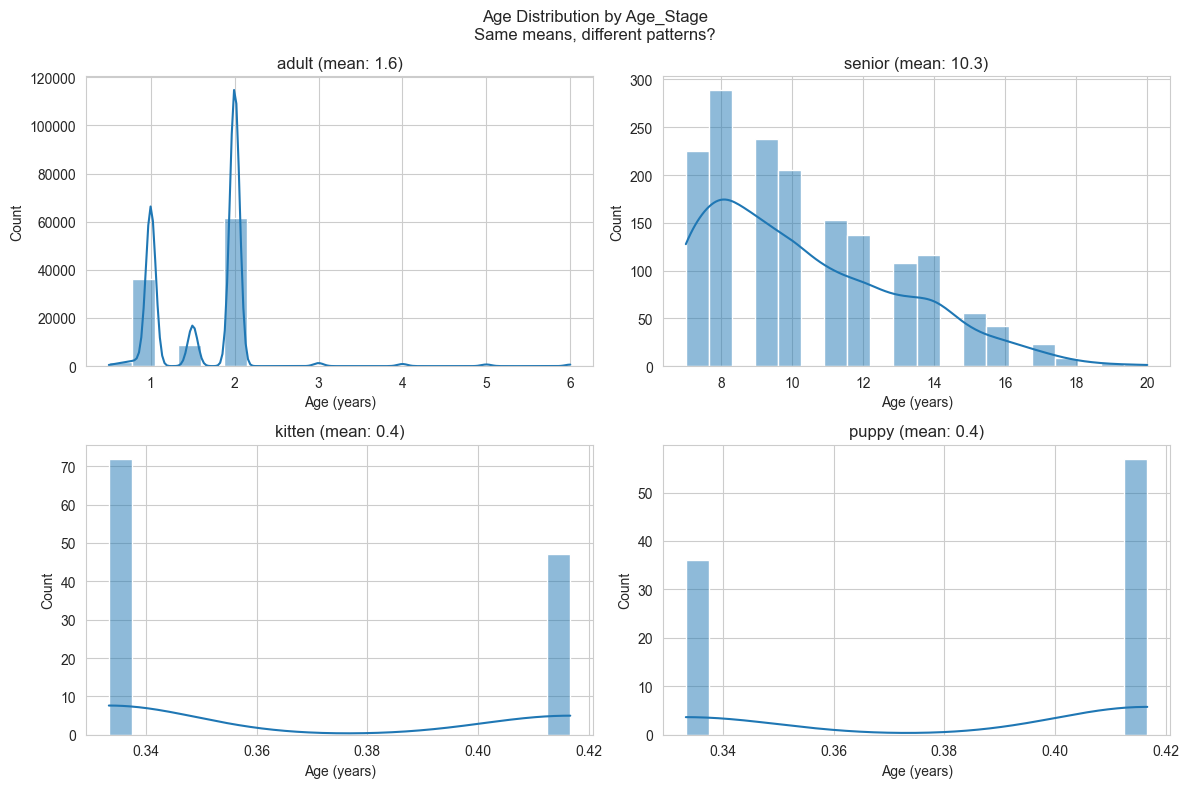

In [80]:
silver_df = compute_age_from_dates(silver_df)
silver_df = impute_missing_age(silver_df)
silver_df = bin_age_into_life_stages(silver_df)

plot_age_distribution_anscombe_style(silver_df, category_col="age_stage")

#### 8.2 Extract Sex and Impute Missing Values Based on Group Distribution

> Note: Missspelled function name need to fix

In [81]:
silver_df = recatogarize_sex(silver_df)
silver_df = impute_sex_by_species_and_breed(silver_df)

#### 8.3 Apply Imputation to Assign Primary Color for Missing Values

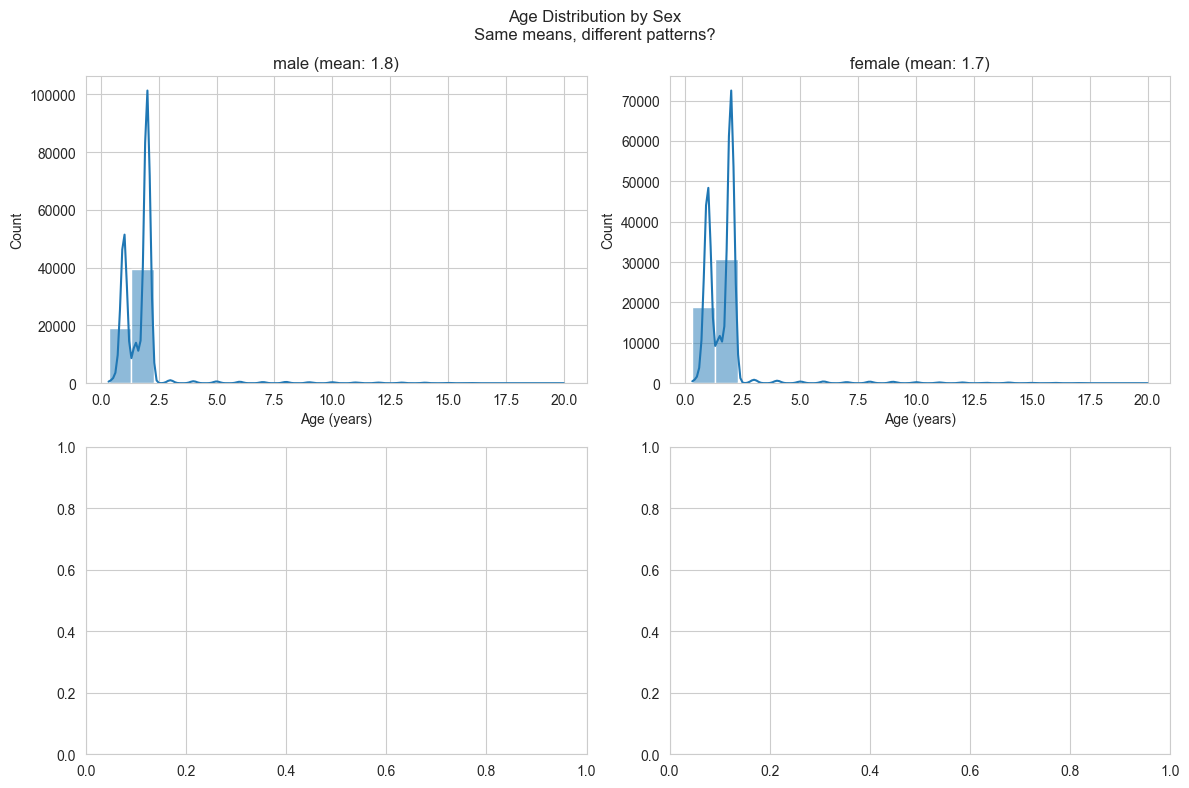

In [82]:
silver_df = impute_primary_color_by_species_and_breed(silver_df)

plot_age_distribution_anscombe_style(silver_df, category_col="sex")

-----

## 9. Materialize Silver

**Purpose:**  
Materialize the final Silver data, with all the cleaning done above.

This allows us to build Gold on top of this cleaned data, without having to re-process the data every time. This makes the work more efficient, and follows best practices. 

All ad-hoc analytics, data exploration, analysis, etc. should be done on top of this data, as it is validated and consistent. This sets a strong foundation for the rest of the data work for our team.

Since we do not have a Database, as is common when using Medallion architecture, we are materializing the data by writing it to `.parquet`. Parquet allows for faster analysis, preserves data types for data, and is an efficient standard for data-storage.

In [83]:
SILVER_DF_PATH = "../../data-assets/silver/silver.parquet"
os.makedirs(os.path.dirname(SILVER_DF_PATH), exist_ok=True)

silver_df.to_parquet(SILVER_DF_PATH, index=False)
print(f"Saved silver df to {SILVER_DF_PATH}")

Saved silver df to ../../data-assets/silver/silver.parquet


----

## 10. Data Quality Assessment

Comprehensive quality checks and data profiling.

In [84]:
# Lets generate the data profile for the silver dataset
generate_data_overview(silver_df)

DATA QUALITY PROFILE

DATASET OVERVIEW
Total records: 111,907
Total columns: 14

MISSING DATA ANALYSIS
  intake_date: 1 (0.001%)
  outcome_date: 2,134 (1.907%)

CARDINALITY ANALYSIS
  animal_id: 91,523 unique values
  intake_date: 3,984 unique values
  outcome_date: 3,599 unique values
  age: 29 unique values
  primary_color: 16 unique values
  outcome_type: 16 unique values
  breed: 14 unique values
  intake_type: 13 unique values
  intake_reason: 12 unique values
  intake_condition: 8 unique values
  age_stage: 4 unique values
  animal_type: 3 unique values
  region: 3 unique values
  sex: 2 unique values

INTAKE_TYPE DISTRIBUTION
  stray: 59.3%
  surrender: 12.1%
  foster: 11.4%
  confiscated: 6.5%
  treatment: 3.0%
  disposal_request: 2.2%
  wildlife: 1.8%
  protective_custody: 1.7%
  spay_neuter: 0.9%
  transfer: 0.7%

ANIMAL_TYPE DISTRIBUTION
  dog: 56.9%
  cat: 35.0%
  other: 8.1%

BREED DISTRIBUTION
  other: 53.5%
  cat_short_hair: 29.6%
  pit_bull: 5.3%
  german_shepherd: 3.0%

/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_43242/3653317606.py:222: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index("intake_date").resample("M").size()


-----

## 11. References  
Databricks. (n.d.). *Medallion Architecture*. Retrieved May 10, 2025, from https://www.databricks.com/glossary/medallion-architecture